In [120]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import jsonref

import pylatex
# import subprocess # to download arxiv.sty from GH
from pylatex import Document, Section, Subsection, Tabular,  Tabularx, LongTabularx, MultiColumn, MultiRow, NoEscape, Figure, Package, Command, LineBreak, NewLine
from pylatex.utils import bold

## Building Pylatex Library

Two ways to build it:<br>
(A) Create an instance of `Document()` and use that as my `self.doc`

(B) Inherit from the `Document()` class [(Ref)](https://jeltef.github.io/PyLaTeX/current/pylatex/document.html) and add the content in latex style directly.
[An Example Here.](https://jeltef.github.io/PyLaTeX/current/examples/basic_inheritance.html)

In [82]:
s1 = mySection("Section2", "Methods", 2)
s1.initialize(s1.fpath)
s1.content = 'These are some of the underhanded methods we used.' 
    # or open up the file and add to it directly
s1.makeSectionTex()

Created directory at ../report/sections


# Library

In [270]:
class Report():
    def __init__(self, name):
        self.name = name
        self.title = ""
        self.fpath = os.path.join("../report", self.name)
        self.outputPath = os.path.join(self.fpath, "output")
        self.doc = Document()
        self.objects = ["sections", "tables", "figures", "mappingTables"]
        return 
    
    def makeDirs(self, dirPath):
        # Helper function to make Directories
        if not os.path.exists(dirPath):
            os.makedirs(dirPath)
            print("Created directory at", dirPath)
        else: 
            print(dirPath, "already exists.")
        return
        
    def initialize(self, fpath):
        ## Initialize a report project
        # Make Directory
        self.makeDirs(fpath)
        
        # Make sub-directories
        subs = self.objects + ["output"] 
        for sub in subs:
            self.makeDirs(os.path.join(fpath,sub))
            
        # Add packages and preamble to Document. 
        pkgs_to_add = [ "booktabs","hyperref","lipsum","microtype", \
                        "nicefrac","url","bookmark","tabularx", "svg"]
        pream_to_add = {
                        "title"  : f"{self.name}",
                        "author" : "Insert your name here",
                        "date"   : "Insert Date here"
        }
        for pkg in pkgs_to_add:
            self.doc.packages.append(Package(pkg))
        for pa in pream_to_add:
            self.doc.preamble.append(Command(pa, pream_to_add[pa]))
        self.doc.append(NoEscape(r"\maketitle"))
       
        return 

    def use_arxiv(self):
        # Add arxiv.sty file from arxiv-style repo on GH if doesn"t exist
        args = ["git", "clone", "--depth=1", "https://github.com/kourgeorge/arxiv-style/blob/master/arxiv.sty"]
        res = subprocess.Popen(args, stdout=subprocess.PIPE)
        self.doc.packages.append(Package("arxiv"))
        return
   
    ########################### ADDING TABLES ########################
    
    def saveTable(self, name, data, path="../tables/", caption="", override=False):
        """
        Given a pandas dataframe, save to this report's tables/path as a tex file
            if it doesn't yet exist. (Option to override even if it exists.)
        """
        
        if not os.path.exists(os.path.join(path,name+".tex") or override=True:
            # if data provided, save data to path as Tex
            if isinstance(data, list): 
                dataOut = pd.concat(data, axis=1, sort=False)
                dataOut.fillna(0, inplace=True)
            else: 
                dataOut = data.copy()

            tbl_width = len(dataOut)
            with open(self.tables[name]["path"],"w") as tf:
                if tbl_width > 10:
                    tf.write(r"\setlength{\tabcolsep}{2pt}")
                    tf.write(r"\resizebox{0.95\textwidth}{!}{")

                tf.write(dataOut.to_latex(multirow=True, float_format="%0.0f")) 
                if caption != "": tf.write(r"\caption{" + caption + r"}")
                
                if tbl_width > 10:
                    tf.write(r"}")

        else: 
            if os.path.exists(os.path.join(path,name)):
                print("Error: tex file already exists in path.")
        return

    def addTbl2Doc(self, tbl):
        """
        Add a table by name to the latex document if it exists in the folder.
        """
        tblFile = os.path.join(self.fpath, "tables", tbl + ".tex")
        if not os.path.exists(tblFile):
            print(f"Error: {tblFile} does not exist. Please save first and try again.")
        else:
            tblInputPath = os.path.join("../tables", tbl + ".tex") #self.tables[tbl]["inpPath"]
            self.doc.append(NoEscape(r"\input{" + tblInputPath + r"}")) 
            print(f"Added {tbl} to the tex doc obj.")
        return
    
    
    ########################## ADDING FIGURES ###########################
    
    
    def saveFigure(self, name, inPath="", savePath="../figures/", caption="", option="", override=False):
        """
        Given an image file path, save that image to this report's figures/path 
            if it doesn't exist yet. (Option to override even if it exists.)
        """
        outFile = os.path.join(savePath, name + ".png")
        if (not os.path.exists(outFile) and inPath != "") or override=True:
            print(f"Error: {name}.png file does not exist in {savePath}. \
                  Saving now.")
            shutil.copyfile(inPath, outFile)
        elif inPath == "":
            print('No input path provided. Image not found.')
        elif os.path.exists(outFile):
            print(f"{outFile} already exists in {savePath}.")

        return
    
    def addFig2Doc(self, fig):
        """fig = dict? or name"""
        if not os.path.exists(self.figures[fig]["path"]):
            print("Error: File does not exist!")
        else:
            figRefPath = self.figures[fig]["inpPath"]

            with self.doc.create(Figure(position="!ht")) as fig_:
                ## To adjust image size given specified options: 
                if "option" in self.figures[fig]:
                    fig_.append(NoEscape(r"\centering"))
                    fig_.append(Command("includegraphics", 
                                    options=(self.figures[fig]["option"]), 
                                    arguments=figRefPath))
                else:
                    fig_.add_image(figRefPath) # default uses 0.8\textwidth 
                if "caption" in self.figures[fig]:
                    fig_.add_caption(self.figures[fig]["caption"])
                print(f"Added {fig} to the tex doc obj")
        return

    
    ######################## ADDING STUFF ############################
    
    
    def addText2Doc(self, text):
        """Add a raw string of text to the Document."""
        self.doc.append(NoEscape(text))
        return 

    def sectionLevel(self, level, title):
        if level == 1:
            return Section(title)
        elif level == 2:
            return Subsection(title)
        elif level == 3:
            return Subsubsection(title)
        else:
            print("Error: invalid section level given.")
        return
    
    def addSection(self, name, level=1, override=False):
        sect = self.sectionLevel(self.level, name)
        sectPath = os.path.join(self.fpath, "sections",  name+".tex")
        if not os.path.exists(sectPath) or override=True:
            with open(sectPath, "w") as tf:
                tf.write(sect.dumps())
            print(f"Created section {name} at {sectPath}")
        else:
            print(f"{secP}")
        return
    
    def addSections(self, name, level=1):
        """Adds a section for each TEX file that exist in the sectPath"""
        
        sectPath = os.path.join(self.fpath, "sections")
        
        for sect in os.listdir(sectPath): 
            # add it to the main doc.
            sectFile = os.path.join("../sections", sect)
            self.addText2Doc(r"\input{" + sectFile + r"}")
            
            # add it to the list of existing sections.
            self.sections.append(sect)
            print(f">> Added Section {sect}")
            
        print(f"\nCurrent list of sections:\n {self.sections}")
        return 
    
    def addAppendix(self):
        appenPath = os.path.join(self.fpath, "mappingTables")

        self.addText2Doc(r"\clearpage") # page break
        for apdx in os.listdir(appenPath): 
            mappingTable = pd.read_csv(os.path.join(appenPath, apdx), header=None)
            colNum = len(mappingTable.columns)

            if colNum == 2:
                hdr_format = "l X[l]"
                col_names = ["Original", "Category"]
                mappingTable.columns = col_names
                mappingTable = mappingTable.groupby("Category")["Original"].apply(list).reset_index()
                tbl_type = LongTabularx(hdr_format, width_argument=NoEscape(r"0.9\textwidth"))

            elif colNum == 3:
                hdr_format = "l l l"
                col_names = ["Lower","Upper","Category"]
                tbl_type = Tabular(hdr_format)

            self.doc.append(bold(NoEscape(r"{} Mapping Table\\".format(apdx.replace("_", " ")))))

            with self.doc.create(tbl_type) as appendix:
                appendix.add_hline()
                appendix.add_row(col_names) 
                appendix.add_hline()

                if colNum == 2: 
                    appendix.end_table_header()
                    appendix.add_hline()
                    appendix.add_row((MultiColumn(colNum, align="r",
                                                    data="Continued on Next Page"),))
                    appendix.end_table_footer()
                    appendix.add_hline()
                    appendix.add_row((MultiColumn(colNum, align="r",
                                        data="Not Continued on Next Page"),))
                    appendix.end_table_last_footer()

                # Iterate through each row in the csv. 
                for i, rw in mappingTable.iterrows():
                    row = [rw[j] for j in range(colNum)]
                    appendix.add_row(row)

                appendix.add_hline()
            self.doc.append(LineBreak())
            self.doc.append(LineBreak())
            self.doc.append(LineBreak())
        
        return
    
    
    ########################## MAKING THE REPORT ##########################
        
        
    def makeReport(self, reportName = "report", tex_only=False):
        """Automated generation of report structure"""
        ## Premable/Packages are added when Report() is initialized.
        
        ## insert report content from dictionary
        
        # For section inside the folder, add sections
        sectPath = os.path.join(self.fpath, "sections")
        for sect in os.listdir(sectPath): 
            sectFile = os.path.join("../sections", sect)
            self.addText2Doc(r"\input{" + sectFile + r"}")
            
        # For figures inside the folder, add figures
        figPath = os.path.join(self.fpath, "figures")
        self.doc.create(Section("Figures"))
        for fig in os.listdir(figPath):
            if fig in self.figures: self.addFig2Doc(fig)
            
        # For tables inside the folder, add tables
        tblPath = os.path.join(self.fpath, "tables")
        self.doc.create(Section("Tables"))
        for tbl in os.listdir(tblPath):
            if tbl in self.tables: self.addTbl2Doc(tbl)

        # For apx inside the folder, add apx
        self.addAppendix()
        
        ## generate tex/pdf
        if tex_only:
            self.doc.generate_tex(os.path.join(self.outputPath, self.name))
        else:
            self.doc.generate_pdf(os.path.join(self.outputPath, self.name), 
                                  clean_tex=False)

        return 


## Using the LatexLibrary 
### 1. Initialize a Report Document
Create a report, give it a name, a title. <br>
Initialize to create the relevant directories. 

In [196]:
doc1 = myReport("Test1")
doc1.title = "My Report"
doc1.initialize(doc1.fpath)

../report/Test1 already exists.
../report/Test1/pdf already exists.
../report/Test1/sections already exists.
../report/Test1/tables already exists.
../report/Test1/figures already exists.
../report/Test1/mappingTables already exists.


### 2. Add Report Content
Either:
1. Add data to the respective folders, run `makeReport()` to generate instantly, 

In [161]:
## Option 1
# manually add data to the initialized folders. then:
# add names and paths to the dictionary? 
doc1.makeReport()

>> Added Section section1.tex

Current list of sections:
 ['section1.tex']
Added  out30.png
Added  out20.png
Added  out10.png

Current list of figures:
 dict_keys(['out30.png', 'out20.png', 'out10.png'])


or **Option 2**
2. Use the `addX()` functions to add to the `myReport()` instance you created. then run `generate_pdf()`

In [245]:
doc2 = myReport("Test2")
doc2.title = "Latex Report Generation: Option 2 Example"
doc2.initialize(doc2.fpath)
doc2.setUpReport()

../report/Test2 already exists.
../report/Test2/output already exists.
../report/Test2/sections already exists.
../report/Test2/tables already exists.
../report/Test2/figures already exists.
../report/Test2/mappingTables already exists.


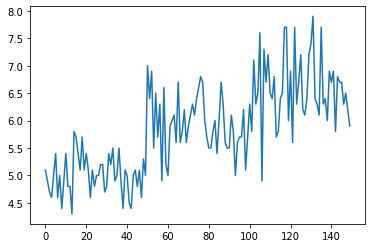

In [234]:
# some sample data
table2_df = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')
plt.plot(table2_df.sepal_length)

imagePath = os.path.join(doc2.fpath, "figures", "figure1.png")
if not os.path.exists(imagePath):
    plt.savefig(imagePath)

In [240]:
#Adding Text
doc2.doc.append(f'This report is titled: {doc2.title}')
doc2.doc.append(LineBreak())
doc2.addText2Doc(r'This is how you add some random text about the report.\\')

#Adding a pandas DF (meanwhile saving it to folder)
doc2.saveTable(name='Table 2',
                 data=table2_df, #'./tables/table2.pkl',
                 path=os.path.join(doc2.fpath, 'tables/table2.tex'),
                 caption='This is a wide table of numbers.')

#Adding a figure (meanwhile saving it to folder)
doc2.saveFigure(name='Figure 1', 
                path='./figures/figure1.png',
                caption='Some descriptive caption',
                option='scale=0.9')

# #Adds all saved figures in the doc2.figures dictionary.
# doc2.addFigures()
# doc2.addTables()
doc2.addFig2Doc('Figure 1')
doc2.addTbl2Doc('Table 2')

In [243]:
doc2.doc.generate_tex(os.path.join(doc2.outputPath,doc2.name))

Added Figure 1 to the tex doc obj
Added Table 2 to the tex doc obj.


### Testing

In [271]:
doc3 = myReport("Test3")
doc3.title = "Latex Report Generation"
doc3.initialize(doc3.fpath)

Created directory at ../report/Test3
Created directory at ../report/Test3/output
Created directory at ../report/Test3/sections
Created directory at ../report/Test3/tables
Created directory at ../report/Test3/figures
Created directory at ../report/Test3/mappingTables


In [261]:
doc3.saveFigure(name='Figure 1', 
                path=os.path.join(doc3.fpath, 'figures/figure1.png'),
                caption='Some descriptive caption',
                option='scale=0.9')

Error: png file does not exist in path. Please save first.


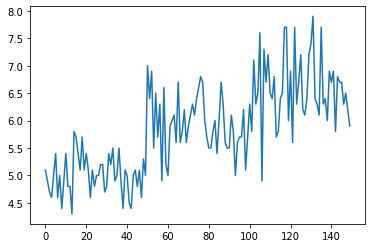

In [253]:
plt.plot(table2_df.sepal_length)
plt.savefig(os.path.join(doc3.fpath, 'figures/figure1.png'))

In [267]:
doc3.saveFigure(name='Figure 1', 
                path=os.path.join(doc3.fpath, 'figures/figure1.png'),
                caption='Some descriptive caption',
                option='scale=0.9')

In [273]:
doc3.saveTable(name='Table 2',
             data=table2_df, 
             path=os.path.join(doc3.fpath, 'tables/table2.tex'),
             caption='This is a table of numbers.')

In [ ]:
# Add Sections
doc3.addSection('Introduction')
doc3.addSection('Methodology')
doc3.addSection('Data Collection', level=2)
doc3.addSection('Models', level=2)
doc3.addSection('Results')
doc3.addSection('Discussion')
doc3.addSection('Conclusion')


In [278]:
doc3.makeReport()

Added Table 2 to the tex doc obj.
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./Test3.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/base/fontenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texmf/tex/latex/lm/lmodern.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/t

CalledProcessError: Command '['pdflatex', '--interaction=nonstopmode', 'Test3.tex']' returned non-zero exit status 1.

## Reference: Classes Example 
From Sankha

In [168]:
# This will sit inside the lib folder. 
class Report():
    
    def __init__(self, name, fpath):
        self.name = name
        self.fpath = fpath
        self.title = ''
        self.sections = []
        self.tables = []
        self.images = []
        return
    
    def initialize(self, dirPath='../report/test'):
        """Create an environment for this report
        """
        if not os.path.exists(dirPath):
            os.makedirs(dirPath)
            print('Created directory at', dirPath)
    
    def addSection(self, sectionTitle, sectionText):
        self.sections.append(
            {
                "sectionTitle": sectionTitle,
                "sectionText": sectionText,
            })
        return
    
    def addTable(self, df, tableNo, tableTitle):
        self.initialize('../report/tables')
        self.tables.append(
        {
                "tableTitle": tableTitle, 
                "tableNo"   : tableNo,
                "tableData" : df
        })
        return
    
    def addFigure(self, path, figNo, figTitle):
        self.initialize('../report/figures')
        
        return
    
    def showReport(self):
        
        report = f'''
        {self.title}'''
        
        for i, section in enumerate(self.sections):
            temp = f'\n{i+1}. {section["sectionTitle"]}\n {section["sectionText"]}\n\n'
            report += temp
            
        print(report)
        
        return
    
    

In [169]:
rep1 = Report('report1', '../report')
rep1.initialize()
rep1.title = 'Cool Report Title'
rep1.addSection('Introduction', 'This is some informamtion about the introduciton')
rep1.addTable("somedata",1, "Table 1")
rep1.addSection('Conclusion', 'This is it')
rep1.showReport()

Created directory at ../report/test
Created directory at ../report/tables

        Cool Report Title
1. Introduction
 This is some informamtion about the introduciton


2. Conclusion
 This is it


